In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import pandas_datareader.data as web
from pandas import Series, DataFrame


/home/umesh/.local/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### Loading YahooFinance Dataset

Pandas web data reader is an extension of pandas library to communicate with most updated financial data. This will include sources as: Yahoo Finance, Google Finance, Enigma, etc.

We will extract Apple Stocks Price using the following codes:

In [2]:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2020, 1, 6)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.sample(5).T

Date,2019-08-14,2018-12-20,2018-09-25,2018-10-11,2018-09-13
High,2.064400e+02,1.621100e+02,2.228200e+02,2.195000e+02,2.283500e+02
Low,2.025900e+02,1.553000e+02,2.197000e+02,2.123200e+02,2.225700e+02
Open,2.031600e+02,1.604000e+02,2.197500e+02,2.145200e+02,2.235200e+02
Close,2.027500e+02,1.568300e+02,2.221900e+02,2.144500e+02,2.264100e+02
Volume,3.654740e+07,6.477300e+07,2.455440e+07,5.312440e+07,4.170640e+07
Adj Close,2.011201e+02,1.537265e+02,2.170359e+02,2.094754e+02,2.211580e+02


### Rolling Mean

In [3]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail()

Date
2019-12-30    238.774814
2019-12-31    239.686144
2020-01-02    240.680702
2020-01-03    241.651266
2020-01-06    242.561192
Name: Adj Close, dtype: float64

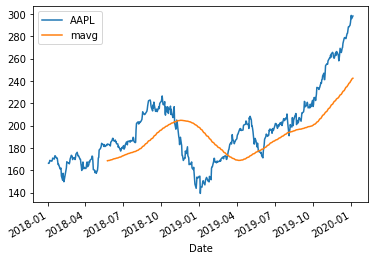

In [4]:
import matplotlib.pyplot as plt

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

$Returns = \frac{(Closing Price Today) - (Closing Price Yesterday)}{Closing Price Yesterday} =   \frac{Closing Price Today}{Closing Price Yesterday}-1$

$ $

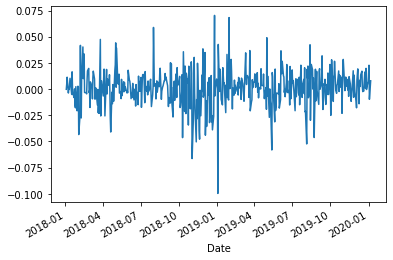

In [5]:
rets = close_px / close_px.shift(1) - 1

rets.plot(label='return')

Logically, our ideal stocks should return as high and stable as possible. If you are risk averse(like me), you might want to avoid this stocks as you saw the 10% drop on 1/2019

### Analysing your Competitors Stocks

In [6]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2019-12-30,290.044617,11.052437,1336.140015,129.698105,156.724243
2019-12-31,292.163818,11.132238,1337.020020,130.899277,156.833633
2020-01-02,298.829956,11.900323,1367.369995,132.246933,159.737595
2020-01-03,295.924713,11.940224,1360.660034,131.192245,157.748581
2020-01-06,298.282715,12.109800,1394.209961,130.957886,158.156342


### Correlation Analysis — Does one competitor affect others?

We can analyse the competition by running the percentage change and correlation function in pandas. Percentage change will find how much the price changes compared to the previous day which defines returns. Knowing the correlation will help us see whether the returns are affected by other stocks’ returns

In [7]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

Let’s plot Apple and GE with ScatterPlot to view their return distributions.

Text(0, 0.5, 'Returns GE')

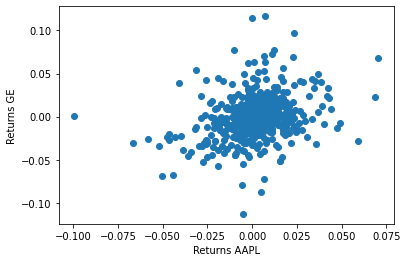

In [8]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

We can see here that there are slight positive correlations among GE returns and Apple returns. It seems like that the higher the Apple returns, the higher GE returns as well for most cases.

Let us further improve our analysis by plotting the scatter_matrix to visualize possible correlations among competing stocks. At the diagonal point, we will run Kernel Density Estimate (KDE). KDE is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample. It helps generate estimations of the overall distributions.

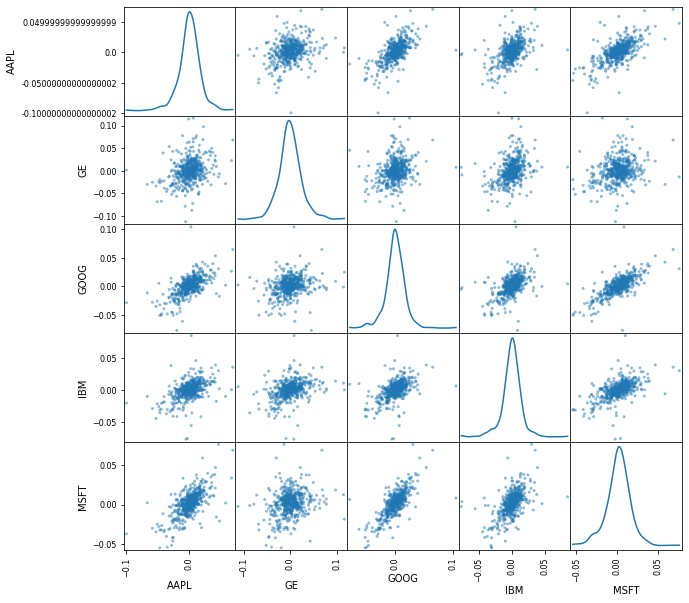

In [9]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

To prove the positive correlations, we will use heat maps to visualize the correlation ranges among the competing stocks. Notice that the lighter the color, the more correlated the two stocks are.

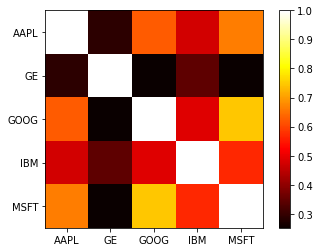

In [10]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

### Stocks Returns Rate and Risk

Apart from correlation, we also analyse each stock’s risks and returns. In this case we are extracting the average of returns (Return Rate) and the standard deviation of returns (Risk).

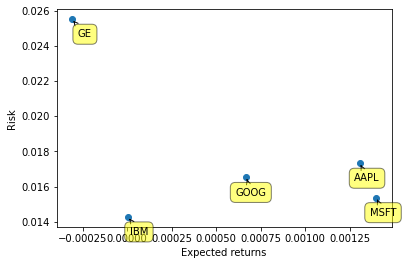

In [11]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

Now you could view this neat chart of risk and return comparisons for competing stocks. Logically, you would like to minimize the risk and maximize returns. Therefore, you would want to draw the line for your risk-return tolerance (The red line). You would then create the rules to buy those stocks under the red line (MSFT, GE, and IBM) and sell those stocks above the red line (AAPL and GOOG). This red line showcases your expected value threshold and your baseline for buy/sell decision.

## Predicting Stocks Price

### Feature Engineering

We will use these three machine learning models to predict our stocks: Simple Linear Analysis, Quadratic Discriminant Analysis (QDA), and K Nearest Neighbor (KNN). But first, let us engineer some features: High Low Percentage and Percentage Change.

In [12]:
# Pick 2 columns
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [13]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2018-01-02,166.353714,25555900.0,1.764779,1.234127
2018-01-03,166.324722,29517900.0,1.503801,-0.173885
2018-01-04,167.097290,22434600.0,0.803329,0.283995
2018-01-05,168.999741,23660000.0,1.325710,0.899445
2018-01-08,168.372040,20567800.0,0.963584,0.000000


### Pre-processing & Cross Validation

We will clean up and process the data using the following steps before putting them into the prediction models:

1. Drop missing value
2. Separating the label here, we want to predict the AdjClose
3. Scale the X so that everyone can have the same distribution for linear regression
4. Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
5. Separate label and identify it as y
6. Separation of training and testing of model by cross validation train test split

In [14]:
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


In [15]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

### Simple Linear Analysis & Quadratic Discriminant Analysis

Simple Linear Analysis shows a linear relationship between two or more variables. When we draw this relationship within two variables, we get a straight line. Quadratic Discriminant Analysis would be similar to Simple Linear Analysis, except that the model allowed polynomial (e.g: x squared) and would produce curves.

We will plug and play the existing Scikit-Learn library and train the model by selecting our X and y train sets. The code will be as following.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [17]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [18]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [19]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [20]:
print(f'The linear regression confidence is {confidencereg}')
print(f'The quadratic regression 2 confidence is {confidencepoly2}')
print(f'The quadratic regression 3 confidence is {confidencepoly3}')
print(f'The knn regression confidence is {confidenceknn}')

The linear regression confidence is 0.9330100951477269
The quadratic regression 2 confidence is 0.9390251548136058
The quadratic regression 3 confidence is 0.9335437834419587
The knn regression confidence is 0.8595019145052017


For sanity testing, let us print some of the stocks forecast.

In [21]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
forecast_set

array([291.80837038, 293.08238406, 295.29138747, 301.59644803,
       299.06694461, 301.11306315])

### Plotting the Prediction

Based on the forecast, we will visualize the plot with our existing historical data. This will help us visualize how the model fares to predict future stocks pricing.

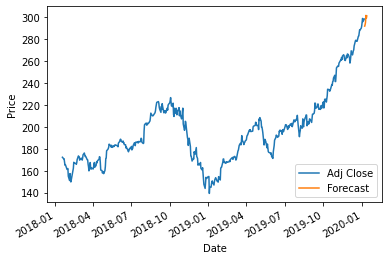

In [22]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()

#plt.figure(figsize=(10,4))
plt.legend(loc=4)

plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

As we can see the blue color showcased the forecast on the stocks price based on regression. The forecast predicted that there would be a downturn for not too long, then it will recover. Therefore, we could buy the stocks during downturn and sell during upturn.